In [5]:
from __future__ import division
import matplotlib
from pylab import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import math
import h5py

In [2]:
fontSize=16
#matplotlib.rcParams.update({"axes.formatter.limits": (-4,4), "svg.fonttype" : "none", 'font.family':'MathJax_SansSerif', 'font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,'text.usetex':False,'text.latex.preamble':[r'\usepackage{sansmath}',r'\sansmath']})
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4), "svg.fonttype" : "none", 'pdf.fonttype':42,'font.family':'DejaVu Sans','font.sans-serif':'Helvetica','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,'text.usetex':False,'text.latex.preamble':[r'\usepackage{sansmath}',r'\sansmath']})
plotStyles={"markersize":8,"markeredgewidth":1.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
barStyles={"width":0.65, "linewidth":0, "align":"center"}

/Users/turtle/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


## Function for autocorrelation analysis
$G(\tau) = \frac{E[I(t)I(t+\tau)]}{E[I(t)]^2}-1$

In [29]:
def cal_autocorr(counts, tau, len_replicate, duration):
    numerator = np.array([]);
    F_i = np.mean(counts[:,0:duration], axis=0);
    for i in range(0, len_replicate):
        n_tmp = counts[i,0:duration-tau]*counts[i,tau:]; #0,1,...,duration-tau-1 ==> 1,2,...,duration - tau
        numerator = np.append(numerator, n_tmp); #tau, tau+1, ..., duration - 1 ==> tau+1, tau+2, ..., duration
    return np.mean(numerator)/(np.mean(F_i)*np.mean(F_i))-1

def get_counts(filename, duration, verbose):
    fp = h5py.File(filename, "r");
    replicates=fp["/Simulations"].keys();
    n = 1; times=fp["/Simulations/%07d/SpeciesCountTimes"%n];
    
    counts = np.zeros((len(replicates), duration));
    for i,replicate in enumerate(replicates):
        counts[i,:] = np.sum(fp["/Simulations/%s/SpeciesCounts"%replicate][-duration:, range(4*num,5*num)], axis=1);

    autocorr = np.zeros(duration);
    for tau in range(0,duration):
        autocorr[tau] = cal_autocorr(counts, tau, len(replicates),duration)
        if verbose == 1:
            print(tau, autocorr[tau])
    return autocorr

## Theoretical model

In [31]:
from scipy.optimize import curve_fit
import decimal

def term1(tau,N,c,k,denom):
    S = 0;
    for n in range(0,N+1):
        S += (N-n)*(N-n+1)*(2*N+n+1)/6*(k*tau)**n/np.math.factorial(n); 
    return S*c/k*np.exp(-k*tau)/denom

def denominator(N,c,k):
    return (c/k)**2*(N*(N+1)/2)**2

decimal.getcontext().prec = 100

term1 = np.vectorize(term1)

def my_func(tau,c,k):
    S = 0;
    denom = (c/k)**2*(N*(N+1)/2)**2; 
    for n in range(0,N+1):
        S = S+(N-n)*(N-n+1)*(2*N+n+1)/6*(k*tau)**n/np.math.factorial(n);
    return S*c/k*np.exp(-k*tau)/denom

my_func = np.vectorize(my_func)

## 1 Simulation -- initiation rate = 0.19
### 1.1 mRNA copy number over time

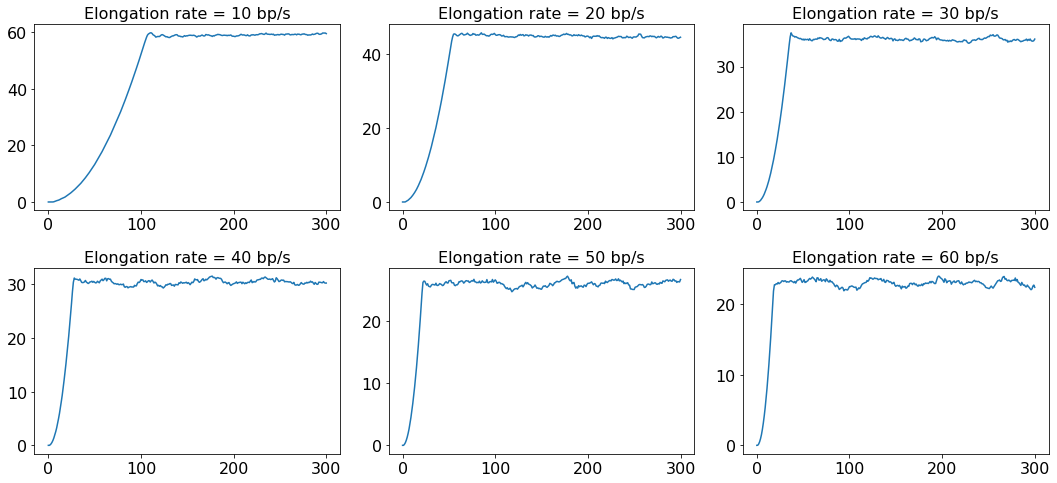

In [7]:
num = 20; 

plt.rcParams["figure.figsize"] = (15,7)
for n_elong in [10,20,30,40,50,60]:
    filename='3endbinding/noSC_3end.0.19.' + str(n_elong) +'.20.lm'
    fp = h5py.File(filename, "r");
    replicates=fp["/Simulations"].keys();
    n = 1; times=fp["/Simulations/%07d/SpeciesCountTimes"%n];
    counts_arr = np.zeros(len(times))
    for i,replicate in enumerate(replicates):
        #counts = np.sum(fp["/Simulations/%s/SpeciesCounts"%replicate][:, range(1*num,3*num)], axis=1);
        counts = np.sum(fp["/Simulations/%s/SpeciesCounts"%replicate][:, range(4*num,5*num)], axis=1);
        counts_arr = counts_arr + counts;
    counts_arr = counts_arr/len(replicates);
    plt.subplot(2,3,int(n_elong/10))
    plt.title('Elongation rate = '+str(n_elong)+' bp/s')
    plt.plot(np.arange(0,len(counts_arr),1), counts_arr)
plt.tight_layout()

### 1.2 empirical initiation rate

In [18]:
num = 20; 

mean_arr = np.array([]);
std_arr = np.array([]); 
for n_elong in [10,20,30,40,50,60]:
    filename='3endbinding/noSC_3end.0.19.' + str(n_elong) +'.20.lm'
    fp = h5py.File(filename, "r");
    replicates=fp["/Simulations"].keys();
    n = 1; times=fp["/Simulations/%07d/SpeciesCountTimes"%n];
    counts_arr = np.array([]); 
    for i,replicate in enumerate(replicates):
        counts = (fp["/Simulations/%s/SpeciesCounts"%replicate][-1, 7*num+1] - fp["/Simulations/%s/SpeciesCounts"%replicate][-201, 7*num+1])/200; 
        counts_arr = np.append(counts_arr, counts); 
    mean_arr = np.append(mean_arr, np.mean(counts_arr));
    std_arr = np.append(std_arr, np.std(counts_arr)); 

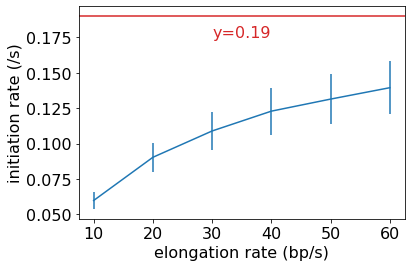

In [23]:
plt.rcParams["figure.figsize"] = (6,4)
x_ = np.array([10,20,30,40,50,60]); 
plt.errorbar(x_, mean_arr, yerr=std_arr);
plt.xlabel('elongation rate (bp/s)')
plt.ylabel('initiation rate (/s)')
plt.axhline(0.19,color='tab:red')
plt.text(30,0.175,'y=0.19',color='tab:red')
plt.tight_layout()

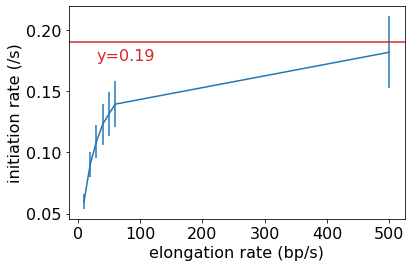

In [25]:
mean_arr = np.array([]);
std_arr = np.array([]); 
for n_elong in [10,20,30,40,50,60,500]:
    filename='3endbinding/noSC_3end.0.19.' + str(n_elong) +'.20.lm'
    fp = h5py.File(filename, "r");
    replicates=fp["/Simulations"].keys();
    n = 1; times=fp["/Simulations/%07d/SpeciesCountTimes"%n];
    counts_arr = np.array([]); 
    for i,replicate in enumerate(replicates):
        counts = (fp["/Simulations/%s/SpeciesCounts"%replicate][-1, 7*num+1] - fp["/Simulations/%s/SpeciesCounts"%replicate][-201, 7*num+1])/200; 
        counts_arr = np.append(counts_arr, counts); 
    mean_arr = np.append(mean_arr, np.mean(counts_arr));
    std_arr = np.append(std_arr, np.std(counts_arr)); 
    
plt.rcParams["figure.figsize"] = (6,4)
x_ = np.array([10,20,30,40,50,60,500]); 
plt.errorbar(x_, mean_arr, yerr=std_arr);
plt.xlabel('elongation rate (bp/s)')
plt.ylabel('initiation rate (/s)')
plt.axhline(0.19,color='tab:red')
plt.text(30,0.175,'y=0.19',color='tab:red')
plt.tight_layout()

### 1.3 autocorrelation analysis

In [36]:
def get_counts2(filename, duration, verbose):
    fp = h5py.File(filename, "r");
    replicates=fp["/Simulations"].keys();
    n = 1; times=fp["/Simulations/%07d/SpeciesCountTimes"%n];
    
    counts = np.zeros((100, duration));
    for i in range(1,101):
        counts[i-1,:] = np.sum(fp["/Simulations/%07d/SpeciesCounts"%i][-duration:, range(4*num,5*num)], axis=1);

    autocorr = np.zeros(duration);
    for tau in range(0,duration):
        autocorr[tau] = cal_autocorr(counts, tau, 100,duration)
        if verbose == 1:
            print(tau, autocorr[tau])
    return autocorr

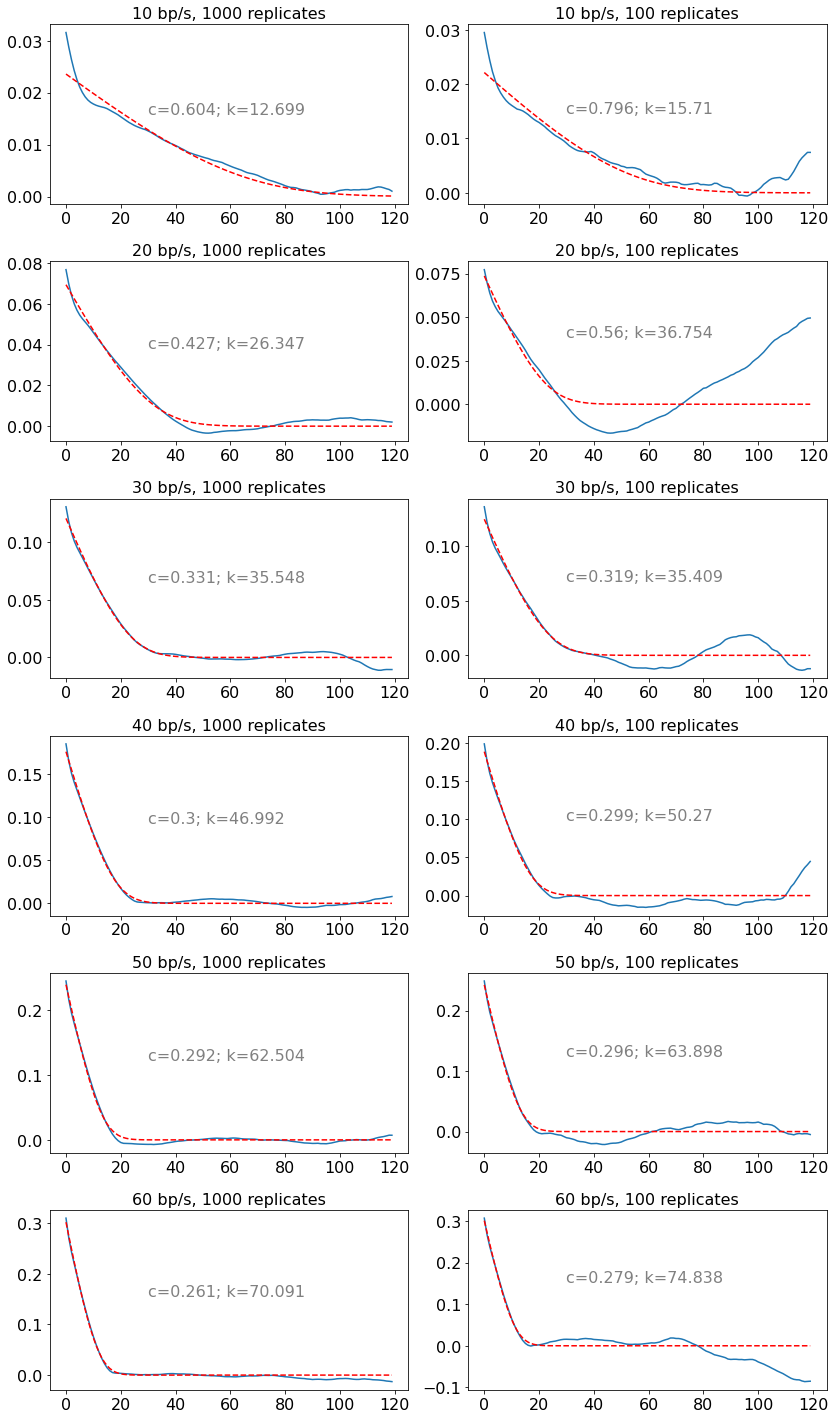

In [38]:
plt.rcParams["figure.figsize"] = (12,20)
kk = 0; 
for n_elong in [10,20,30,40,50,60]:
    myfile='3endbinding/noSC_3end.0.19.' + str(n_elong) +'.20.lm'
    kk = kk +1;
    subplot(6,2,kk)
    autocorr = get_counts(myfile, 150, 0); 
    plt.title(str(n_elong)+' bp/s,'+' 1000 replicates')
    plt.plot(np.arange(0,120),autocorr[:120])
    xdata = np.arange(0,60); ydata2 = autocorr[:60]; 
    xdata2 = np.arange(0,120); 
    popt, pcov = curve_fit(my_func, xdata, ydata2, p0=[0.1,1],maxfev=10000)
    plt.plot(xdata2, my_func(xdata2,*popt),'r--',label='fit')
    plt.text(30,0.5*max(ydata2), 'c='+str(round(popt[0],3))+'; k='+str(round(popt[1]*58,3)),color='gray')

    kk = kk+1;
    subplot(6,2,kk)
    plt.title(str(n_elong)+' bp/s,'+' 100 replicates')
    autocorr2 = get_counts2(myfile, 150, 0); 
    plt.plot(np.arange(0,120),autocorr2[:120])
    xdata = np.arange(0,60); ydata2 = autocorr2[:60]; 
    xdata2 = np.arange(0,120); 
    popt, pcov = curve_fit(my_func, xdata, ydata2, p0=[0.1,1],maxfev=10000)
    plt.plot(xdata2, my_func(xdata2,*popt),'r--',label='fit')
    plt.text(30,0.5*max(ydata2), 'c='+str(round(popt[0],3))+'; k='+str(round(popt[1]*58,3)),color='gray')
    
plt.tight_layout()

### 1.4 autocorrelation analysis (overlay with theoretical prediction) 

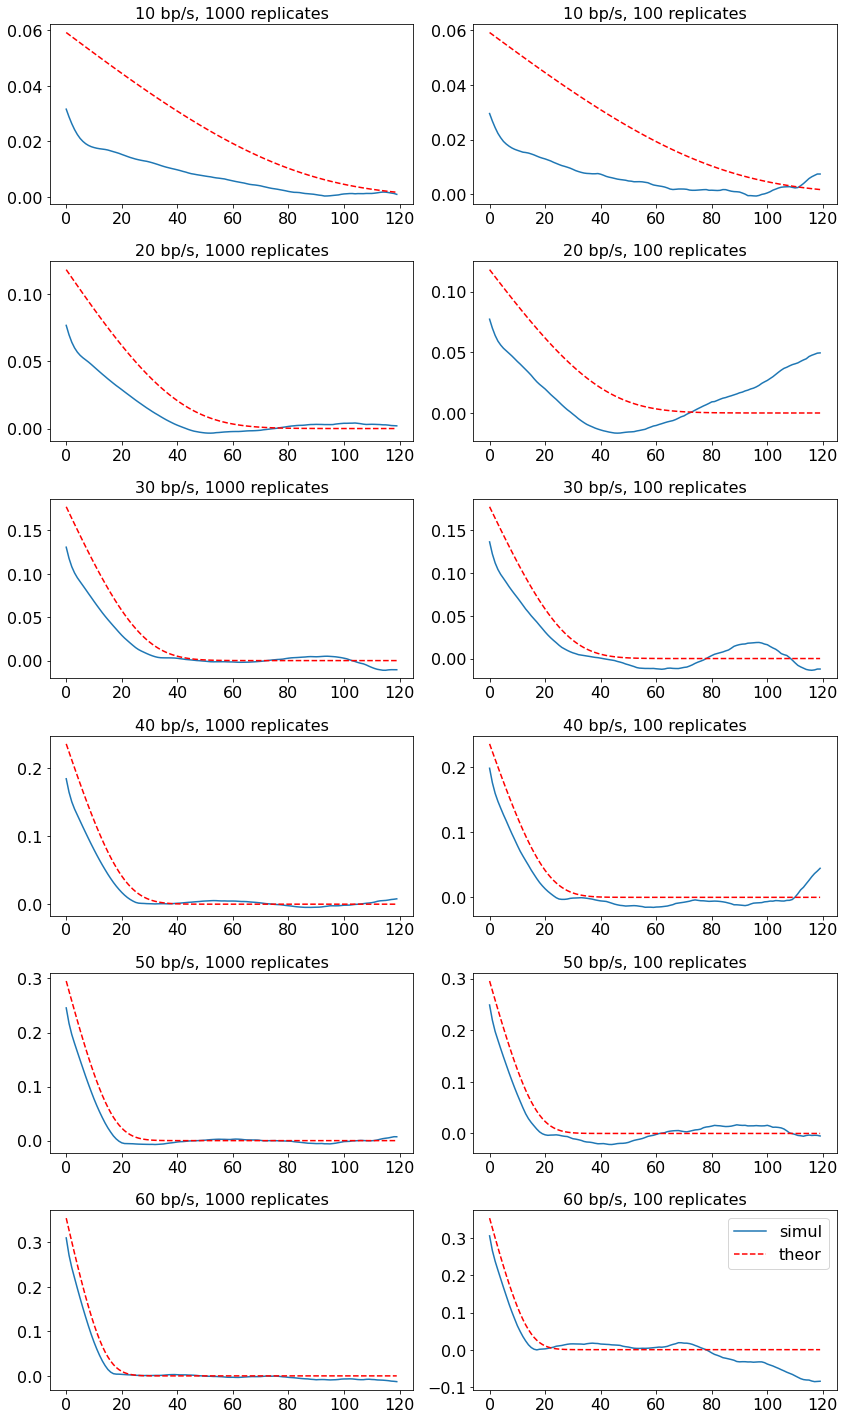

In [41]:
N = 20; 
c = 0.19;
whole_len = 20*58;
single_loop = whole_len/N; 
    
plt.rcParams["figure.figsize"] = (12,20)
kk = 0; 
for n_elong in [10,20,30,40,50,60]:
    myfile='3endbinding/noSC_3end.0.19.' + str(n_elong) +'.20.lm'

    k = n_elong/single_loop;
    
    kk = kk +1;
    subplot(6,2,kk)
    autocorr = get_counts(myfile, 150, 0); 
    plt.title(str(n_elong)+' bp/s,'+' 1000 replicates')
    plt.plot(np.arange(0,120),autocorr[:120], label='simul')
    tau = np.arange(0,120);
    plt.plot(tau, term1(tau,N,c,k,denominator(N,c,k)), 'r--', label='theor');

    kk = kk+1;
    subplot(6,2,kk)
    plt.title(str(n_elong)+' bp/s,'+' 100 replicates')
    autocorr2 = get_counts2(myfile, 150, 0); 
    plt.plot(np.arange(0,120),autocorr2[:120], label='simul')
    tau = np.arange(0,120); 
    plt.plot(tau, term1(tau,N,c,k,denominator(N,c,k)), 'r--', label='theor');
plt.legend()
plt.tight_layout()

## 2 Simulation -- initiation rate = 0.019
### 2.1 mRNA copy number over time

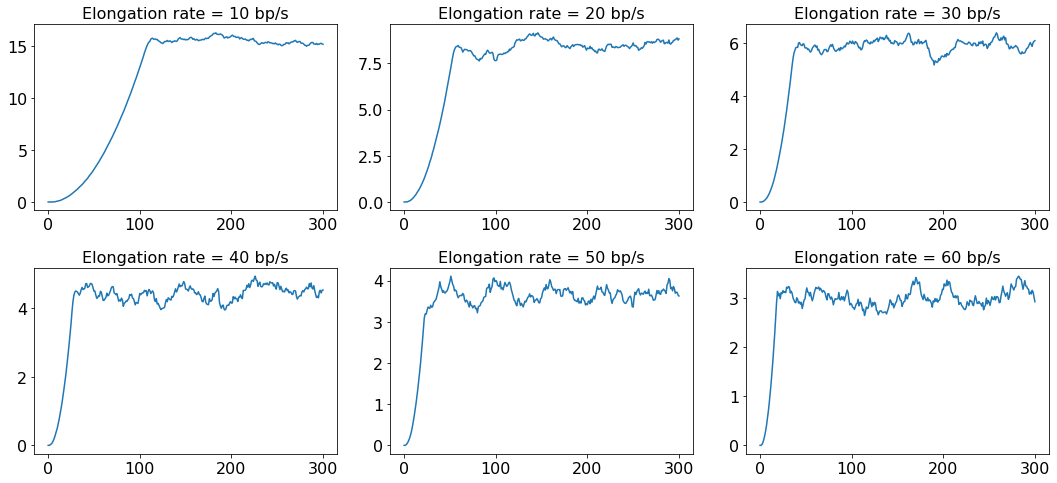

In [28]:
num = 20; 

plt.rcParams["figure.figsize"] = (15,7)
for n_elong in [10,20,30,40,50,60]:
    filename='3endbinding/noSC_3end.0.019.' + str(n_elong) +'.20.lm'
    fp = h5py.File(filename, "r");
    replicates=fp["/Simulations"].keys();
    n = 1; times=fp["/Simulations/%07d/SpeciesCountTimes"%n];
    counts_arr = np.zeros(len(times))
    for i,replicate in enumerate(replicates):
        #counts = np.sum(fp["/Simulations/%s/SpeciesCounts"%replicate][:, range(1*num,3*num)], axis=1);
        counts = np.sum(fp["/Simulations/%s/SpeciesCounts"%replicate][:, range(4*num,5*num)], axis=1);
        counts_arr = counts_arr + counts;
    counts_arr = counts_arr/len(replicates);
    plt.subplot(2,3,int(n_elong/10))
    plt.title('Elongation rate = '+str(n_elong)+' bp/s')
    plt.plot(np.arange(0,len(counts_arr),1), counts_arr)
plt.tight_layout()

### empirical initiation rate (initiation rate = 0.019)

In [26]:
num = 20; 

mean_arr = np.array([]);
std_arr = np.array([]); 
for n_elong in [10,20,30,40,50,60]:
    filename='3endbinding/noSC_3end.0.019.' + str(n_elong) +'.20.lm'
    fp = h5py.File(filename, "r");
    replicates=fp["/Simulations"].keys();
    n = 1; times=fp["/Simulations/%07d/SpeciesCountTimes"%n];
    counts_arr = np.array([]); 
    for i,replicate in enumerate(replicates):
        counts = (fp["/Simulations/%s/SpeciesCounts"%replicate][-1, 7*num+1] - fp["/Simulations/%s/SpeciesCounts"%replicate][-201, 7*num+1])/200; 
        counts_arr = np.append(counts_arr, counts); 
    mean_arr = np.append(mean_arr, np.mean(counts_arr));
    std_arr = np.append(std_arr, np.std(counts_arr)); 
    

### 2.2 empirical initiation rate

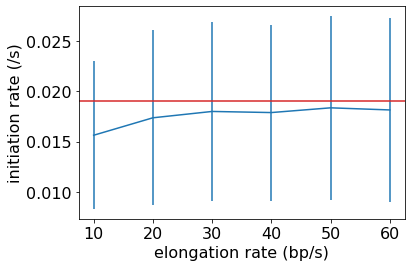

In [27]:
plt.rcParams["figure.figsize"] = (6,4)
x_ = np.array([10,20,30,40,50,60]); 
plt.errorbar(x_, mean_arr, yerr=std_arr);
plt.xlabel('elongation rate (bp/s)')
plt.ylabel('initiation rate (/s)')
plt.axhline(0.019,color='tab:red')
#plt.text(30,0.175,'y=0.19',color='tab:red')
plt.tight_layout()

### 2.3 autocorrelation analysis (overlay with fitting) 

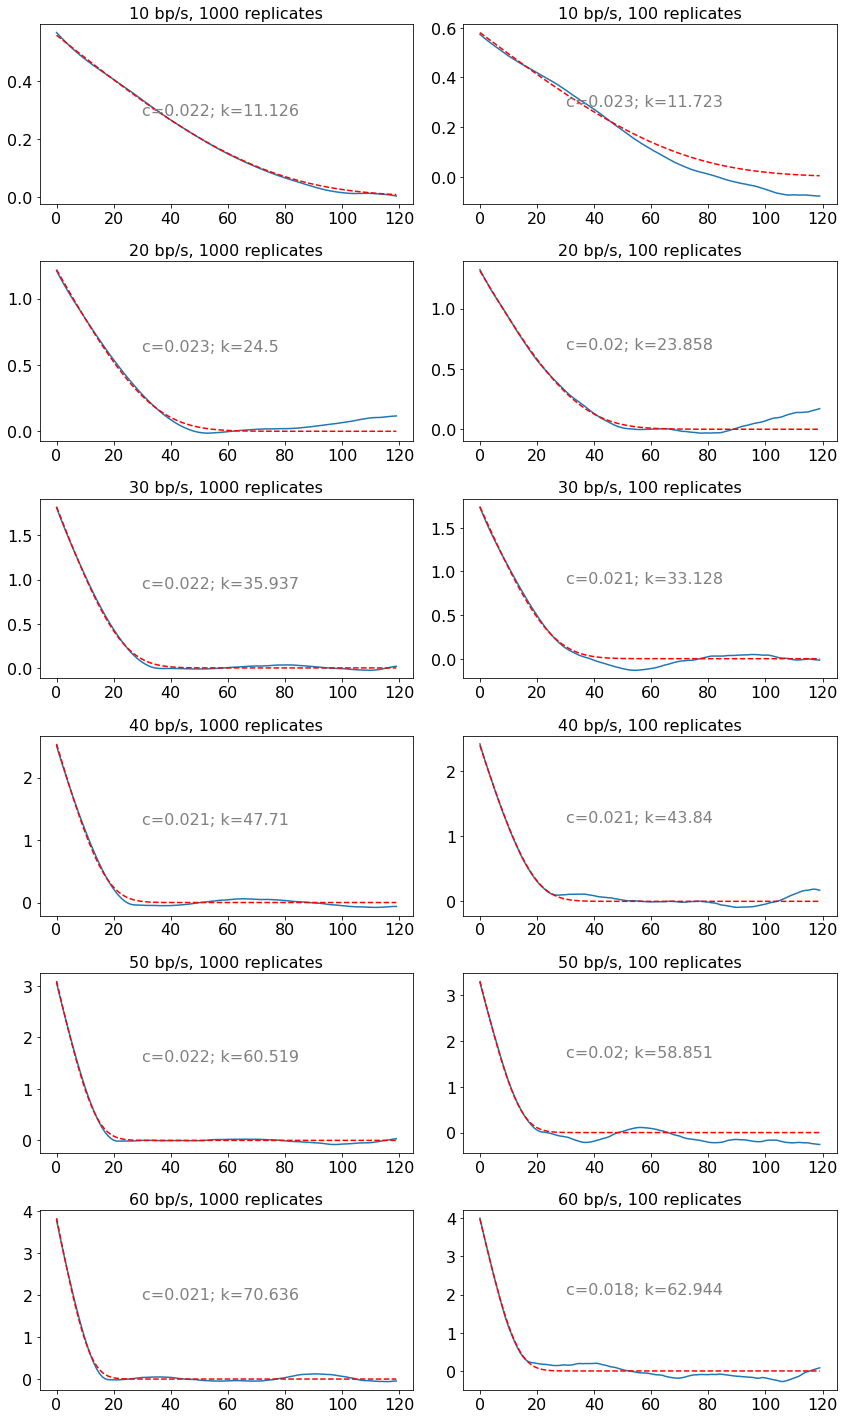

In [39]:
N = 20; 

plt.rcParams["figure.figsize"] = (12,20)
kk = 0; 
for n_elong in [10,20,30,40,50,60]:
    myfile='3endbinding/noSC_3end.0.019.' + str(n_elong) +'.20.lm'
    kk = kk +1;
    subplot(6,2,kk)
    autocorr = get_counts(myfile, 150, 0); 
    plt.title(str(n_elong)+' bp/s,'+' 1000 replicates')
    plt.plot(np.arange(0,120),autocorr[:120])
    xdata = np.arange(0,60); ydata2 = autocorr[:60]; 
    xdata2 = np.arange(0,120); 
    popt, pcov = curve_fit(my_func, xdata, ydata2, p0=[0.1,1],maxfev=10000)
    plt.plot(xdata2, my_func(xdata2,*popt),'r--',label='fit')
    plt.text(30,0.5*max(ydata2), 'c='+str(round(popt[0],3))+'; k='+str(round(popt[1]*58,3)),color='gray')

    kk = kk+1;
    subplot(6,2,kk)
    plt.title(str(n_elong)+' bp/s,'+' 100 replicates')
    autocorr2 = get_counts2(myfile, 150, 0); 
    plt.plot(np.arange(0,120),autocorr2[:120])
    xdata = np.arange(0,60); ydata2 = autocorr2[:60]; 
    xdata2 = np.arange(0,120); 
    popt, pcov = curve_fit(my_func, xdata, ydata2, p0=[0.1,1],maxfev=10000)
    plt.plot(xdata2, my_func(xdata2,*popt),'r--',label='fit')
    plt.text(30,0.5*max(ydata2), 'c='+str(round(popt[0],3))+'; k='+str(round(popt[1]*58,3)),color='gray')
    
plt.tight_layout()

### 2.4 autocorrelation analysis (overlay with theoretical prediction) 

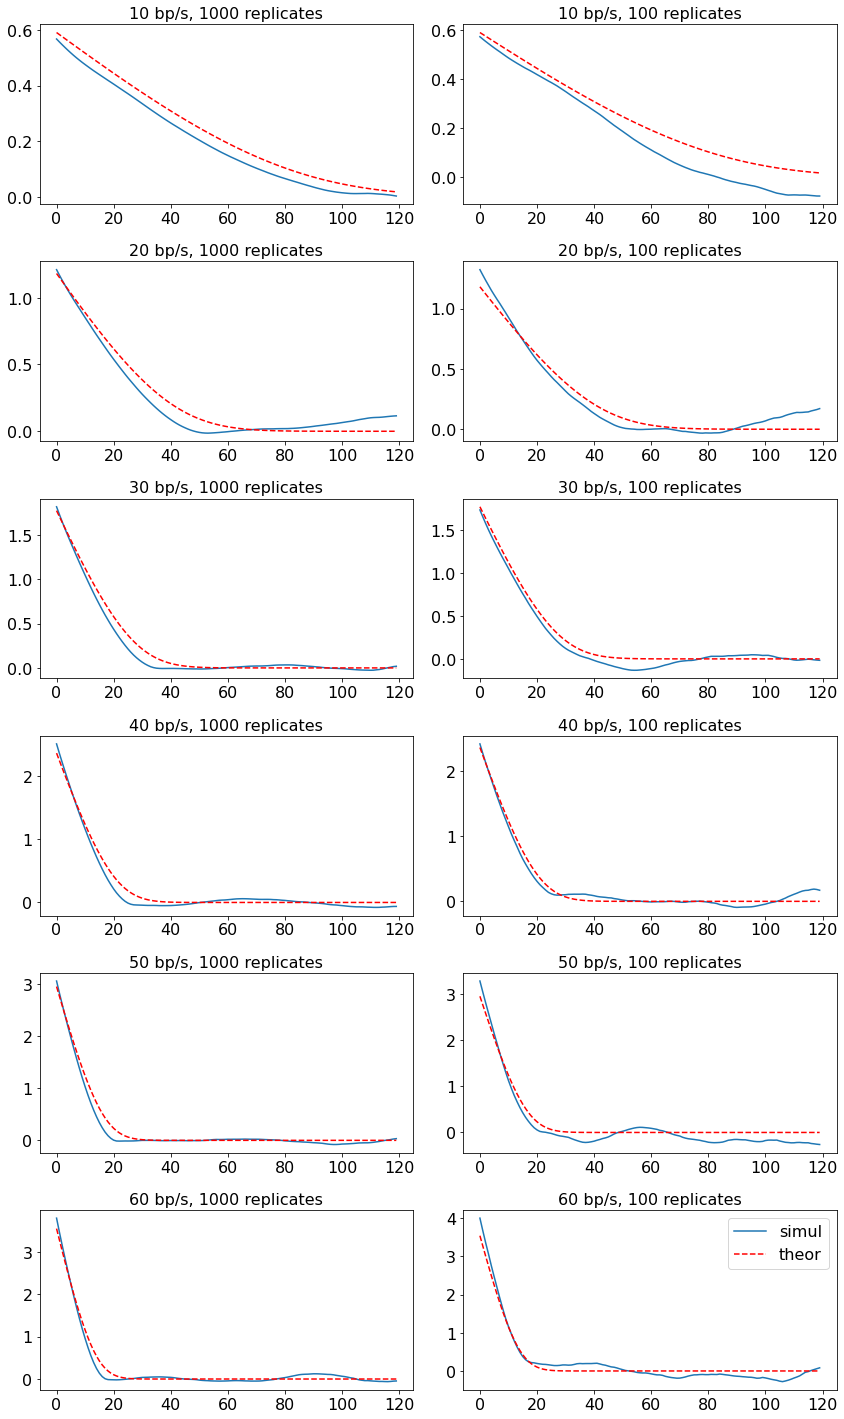

In [40]:
N = 20; 
c = 0.019;
whole_len = 20*58;
single_loop = whole_len/N; 
    
plt.rcParams["figure.figsize"] = (12,20)
kk = 0; 
for n_elong in [10,20,30,40,50,60]:
    myfile='3endbinding/noSC_3end.0.019.' + str(n_elong) +'.20.lm'

    k = n_elong/single_loop;
    
    kk = kk +1;
    subplot(6,2,kk)
    autocorr = get_counts(myfile, 150, 0); 
    plt.title(str(n_elong)+' bp/s,'+' 1000 replicates')
    plt.plot(np.arange(0,120),autocorr[:120], label='simul')
    tau = np.arange(0,120);
    plt.plot(tau, term1(tau,N,c,k,denominator(N,c,k)), 'r--', label='theor');

    kk = kk+1;
    subplot(6,2,kk)
    plt.title(str(n_elong)+' bp/s,'+' 100 replicates')
    autocorr2 = get_counts2(myfile, 150, 0); 
    plt.plot(np.arange(0,120),autocorr2[:120], label='simul')
    tau = np.arange(0,120); 
    plt.plot(tau, term1(tau,N,c,k,denominator(N,c,k)), 'r--', label='theor');
plt.legend()
plt.tight_layout()